In [1]:
import numpy as np
import torch
import pandas as pd
import numpy as np

In [3]:
from matplotlib import pyplot as plt
plt.style.use("seaborn-whitegrid")
from matplotlib.cm import tab10

In [4]:
from tqdm.auto import tqdm

In [5]:
import kcmc
from kcmc.estimators import confounding_robust_estimator, hajek, ipw
from kcmc.experiment_policy_evaluation import run_policy_evaluation_experiment

#from kcmc.data_continuous import evaluate_policy, generate_data, estimate_p_t

# Binary Synthetic Data

In [9]:
from kcmc.data_binary import evaluate_policy, generate_data, estimate_p_t

In [10]:
beta_e_x = np.asarray([0, .75, -.5, 0, -1])

def toy_policy(X, T):
    n = X.shape[0]
    T = torch.as_tensor(T)
    z = torch.as_tensor(X) @ torch.as_tensor(beta_e_x)
    e_x = torch.exp(z) / (1 + torch.exp(z))
    return (1. - T) * e_x + T * (1. - e_x)

In [11]:
# Guessing kernel with approximate solution
Y, T, X, _, _, _ = generate_data(1000)
p_t = estimate_p_t(X, T)
_, w_guess = confounding_robust_estimator(
    Y, T, X, p_t, toy_policy, lambd=1.5,
    hajek_const=True, tan_box_const=True, 
    return_w=True, normalize_p_t=True, 
)
e_guess = p_t * w_guess - 1
gp_kernel = kcmc.estimators.fit_gp_kernel(e_guess, T, X)
kernel = gp_kernel.k2

### Experiment of changing sensitivity parameter $\lambda$ 

In [10]:
def update_base_method(**new_params):
    ret = kcmc.experiment_policy_evaluation.EXAMPLE_PARAMS.copy()
    ret.update(new_params)
    return ret

grid_methods = {
    'ZSB': update_base_method(
        hajek_const=True,
        normalize_p_t=True,
        tan_box_const=True,
    ),
    'GP_KCMC': update_base_method(
        hajek_const=True,
        normalize_p_t=True,
        tan_box_const=True,
        kernel=kernel,
        kernel_const=True,
        D=100,
    ),
    'hard_KCMC': update_base_method(
        hajek_const=True,
        normalize_p_t=True,
        tan_box_const=True,
        kernel=kernel,
        kernel_const=True,
        hard_kernel_const=True,
        D=100,
    ),
    'quantile': update_base_method(
        hajek_const=True,
        normalize_p_t=True,
        tan_box_const=True,
        quantile_const=True,
    ),
}

grid_lambd = [1.0 + 0.01 + 0.1 * i for i in range(11)]

In [11]:
log_file='logs/policy_evaluation_synthetic_binary_changing_lambda.csv'

pbar = tqdm(total=len(grid_methods) * len(grid_lambd))
for method_name, params in grid_methods.items():
    for lambd in grid_lambd:
        params['lambd'] = lambd
        run_policy_evaluation_experiment(
            log_file, params, toy_policy, data_type='synthetic binary', 
            n_seeds=10, sample_size=500, log_info=method_name
        )
        pbar.update(1)
pbar.close()

  0%|          | 0/44 [00:00<?, ?it/s]

In [12]:
df = pd.read_csv('logs/policy_evaluation_synthetic_binary_changing_lambda.csv')

In [13]:
df.head()

,log_info,data_type,policy_name,sample_size,seed,lower_bound,upper_bound,D,lambd,gamma,...,hard_kernel_const,normalize_p_t,f_divergence,hajek_const,kernel_const,quantile_const,regressor_const,tan_box_const,lr_box_const,f_const
0,ZSB,synthetic binary,toy_policy,500,0,3.702457,3.724026,200,1.01,0.01,...,False,True,total variation,True,False,False,False,True,False,False
1,ZSB,synthetic binary,toy_policy,500,1,3.770768,3.796286,200,1.01,0.01,...,False,True,total variation,True,False,False,False,True,False,False
2,ZSB,synthetic binary,toy_policy,500,2,3.535814,3.557641,200,1.01,0.01,...,False,True,total variation,True,False,False,False,True,False,False
3,ZSB,synthetic binary,toy_policy,500,3,3.624325,3.640795,200,1.01,0.01,...,False,True,total variation,True,False,False,False,True,False,False
4,ZSB,synthetic binary,toy_policy,500,4,3.664120,3.686011,200,1.01,0.01,...,False,True,total variation,True,False,False,False,True,False,False


In [14]:
# due to the numerical rounding, some of the original values are invalid indices
grid_lambd = df.lambd.unique()  

In [15]:
df_grouped = df.groupby(by=['log_info', 'lambd'])['lower_bound', 'upper_bound']
values_mean = df_grouped.mean()
values_std = df_grouped.std()

/tmp/ipykernel_1581777/1363206736.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_grouped = df.groupby(by=['log_info', 'lambd'])['lower_bound', 'upper_bound']


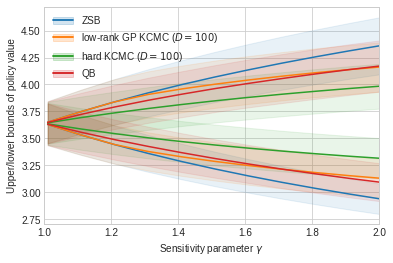

In [20]:
colors = {method: tab10((0.5 + i) / 10) for i, method in enumerate(grid_methods.keys())}
legend_targets = []
legend_tags = ["ZSB", "low-rank GP KCMC ($D=100$)", "hard KCMC ($D=100$)", "QB"]

for method_name in grid_methods.keys():
    upper = np.array([values_mean.loc[(method_name, lambd)]['upper_bound'] for lambd in grid_lambd])
    lower = np.array([values_mean.loc[(method_name, lambd)]['lower_bound'] for lambd in grid_lambd])
    dupper = np.array([values_std.loc[(method_name, lambd)]['upper_bound'] for lambd in grid_lambd])
    dlower = np.array([values_std.loc[(method_name, lambd)]['lower_bound'] for lambd in grid_lambd])
    c = colors[method_name]
    upper_line = plt.plot(grid_lambd, upper, c=c)[0]
    lower_line = plt.plot(grid_lambd, lower, c=c)[0]
    upper_band = plt.fill_between(grid_lambd, upper + dupper, upper - dupper, color=c, alpha=0.1)
    lower_band = plt.fill_between(grid_lambd, lower + dlower, lower - dlower, color=c, alpha=0.1)
    legend_targets.append((upper_line, lower_line, upper_band, lower_band))

plt.legend(legend_targets, legend_tags)
plt.xlabel(r"Sensitivity parameter $\gamma$")
plt.ylabel(r"Upper/lower bounds of policy value")
plt.xlim([1.0, 2.0])
plt.savefig('logs/policy_evaluation_synthetic_binary_changing_lambda.pdf')

### Experiment of changing sample size

In [22]:
def update_base_method(**new_params):
    ret = kcmc.experiment_policy_evaluation.EXAMPLE_PARAMS.copy()
    ret.update(new_params)
    return ret

grid_methods = {
    'ZSB': update_base_method(
        hajek_const=True,
        normalize_p_t=True,
        tan_box_const=True,
    ),
    'GP_KCMC': update_base_method(
        hajek_const=True,
        normalize_p_t=True,
        tan_box_const=True,
        kernel=kernel,
        kernel_const=True,
        # D=n // 5,
    ),
    'hard_KCMC': update_base_method(
        hajek_const=True,
        normalize_p_t=True,
        tan_box_const=True,
        kernel=kernel,
        kernel_const=True,
        hard_kernel_const=True,
        # D=n // 5,
    ),
    'quantile': update_base_method(
        hajek_const=True,
        normalize_p_t=True,
        tan_box_const=True,
        quantile_const=True,
    ),
}

grid_sample_size = [100 * i for i in range(1, 11)]

In [22]:
log_file='logs/policy_evaluation_synthetic_binary_changing_sample_size.csv'

pbar = tqdm(total=len(grid_methods) * sum(n ** 2 for n in grid_sample_size))
for method_name, params in grid_methods.items():
    for n in grid_sample_size:
        params['D'] = n // 5
        run_policy_evaluation_experiment(
            log_file, params, toy_policy, data_type='synthetic binary', 
            n_seeds=10, sample_size=n, log_info=method_name
        )
        pbar.update(n ** 2)
pbar.close()

  0%|          | 0/15400000 [00:00<?, ?it/s]

Encountered error for data_type=synthetic binary, sample_size=800, params={'D': 160, 'lambd': 1.5, 'gamma': 0.01, 'alpha': 0.05, 'sigma2': 0.01, 'kernel': RBF(length_scale=1), 'hard_kernel_const': False, 'normalize_p_t': True, 'f_divergence': 'total variation', 'hajek_const': True, 'kernel_const': False, 'quantile_const': True, 'regressor_const': False, 'tan_box_const': True, 'lr_box_const': False, 'f_const': False}. Skipping the experiment.


In [17]:
df = pd.read_csv('logs/policy_evaluation_synthetic_binary_changing_sample_size.csv')

In [18]:
df.head()

,log_info,data_type,policy_name,sample_size,seed,lower_bound,upper_bound,D,lambd,gamma,...,hard_kernel_const,normalize_p_t,f_divergence,hajek_const,kernel_const,quantile_const,regressor_const,tan_box_const,lr_box_const,f_const
0,ZSB,synthetic binary,toy_policy,100,0,3.663569,4.607054,20,1.5,0.01,...,False,True,total variation,True,False,False,False,True,False,False
1,ZSB,synthetic binary,toy_policy,100,1,3.335259,3.980575,20,1.5,0.01,...,False,True,total variation,True,False,False,False,True,False,False
2,ZSB,synthetic binary,toy_policy,100,2,2.288669,2.818702,20,1.5,0.01,...,False,True,total variation,True,False,False,False,True,False,False
3,ZSB,synthetic binary,toy_policy,100,3,3.151648,3.922349,20,1.5,0.01,...,False,True,total variation,True,False,False,False,True,False,False
4,ZSB,synthetic binary,toy_policy,100,4,2.758201,3.418388,20,1.5,0.01,...,False,True,total variation,True,False,False,False,True,False,False


In [19]:
df_grouped = df.groupby(by=['log_info', 'sample_size'])['lower_bound', 'upper_bound']
values_mean = df_grouped.mean()
values_std = df_grouped.std()

/tmp/ipykernel_1585830/2653174186.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_grouped = df.groupby(by=['log_info', 'sample_size'])['lower_bound', 'upper_bound']


In [40]:
Y, T, X, _, _, _ = generate_data(100000)
p_t = estimate_p_t(X, T)
ground_truth = ipw(Y, T, X, p_t, toy_policy)

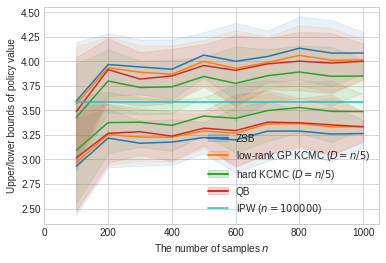

In [42]:
colors = {method: tab10((0.5 + i) / 10) for i, method in enumerate(grid_methods.keys())}
legend_targets = []
legend_tags = ["ZSB", "low-rank GP KCMC ($D=n / 5$)", "hard KCMC ($D=n / 5$)", "QB"]

for method_name in grid_methods.keys():
    upper = np.array([values_mean.loc[(method_name, n)]['upper_bound'] for n in grid_sample_size])
    lower = np.array([values_mean.loc[(method_name, n)]['lower_bound'] for n in grid_sample_size])
    dupper = np.array([values_std.loc[(method_name, n)]['upper_bound'] for n in grid_sample_size])
    dlower = np.array([values_std.loc[(method_name, n)]['lower_bound'] for n in grid_sample_size])
    c = colors[method_name]
    upper_line = plt.plot(grid_sample_size, upper, c=c)[0]
    lower_line = plt.plot(grid_sample_size, lower, c=c)[0]
    upper_band = plt.fill_between(grid_sample_size, upper + dupper, upper - dupper, color=c, alpha=0.1)
    lower_band = plt.fill_between(grid_sample_size, lower + dlower, lower - dlower, color=c, alpha=0.1)
    legend_targets.append((upper_line, lower_line, upper_band, lower_band))

c = tab10((0.5 + i + 1) / 10)
gt_line = plt.plot(grid_sample_size, [ground_truth for _ in grid_sample_size], c=c)[0]
legend_targets.append(gt_line)
legend_tags.append(r"IPW ($n=100000$)")

plt.legend(legend_targets, legend_tags)
plt.xlabel(r"The number of samples $n$")
plt.ylabel(r"Upper/lower bounds of policy value")
plt.xlim([0, 1050])
plt.savefig('logs/policy_evaluation_synthetic_binary_changing_sample_size.pdf')

#### The interpretation of the above plot:
- Since the upper/lower bound's tightness is independent of the sample size by definition, the width of interval should not change significantly for different sample size
- However, the 

# Continuous Synthetic Data

In [12]:
from kcmc.data_continuous import evaluate_policy, generate_data, estimate_p_t

In [13]:
def wrap_continuous_policy(policy):
    def wrapped_policy(X, T=None, return_sample=False, requires_grad=False): 
        policy_dist = policy(X)
        if return_sample:
            return policy_dist.rsample() if requires_grad else policy_dist.sample()
        else:
            return torch.exp(policy_dist.log_prob(torch.as_tensor(T)))
    return wrapped_policy

beta_e_x = np.asarray([0, .75, -.5, 0, -1])

@wrap_continuous_policy
def toy_policy(X):
    z = torch.as_tensor(X) @ torch.as_tensor(beta_e_x)
    mu_t = torch.exp(z) / (1 + torch.exp(z))
    a, b = 3 * mu_t + 1, 3 * (1 - mu_t) + 1
    return torch.distributions.beta.Beta(a, b)

In [14]:
beta_e_x = np.asarray([0, .75, -.5, 0, -1])

def toy_policy(X, T):
    n = X.shape[0]
    T = torch.as_tensor(T)
    z = torch.as_tensor(X) @ torch.as_tensor(beta_e_x)
    e_x = torch.exp(z) / (1 + torch.exp(z))
    return (1. - T) * e_x + T * (1. - e_x)

### Experiment of changing sensitivity parameter $\lambda$ 

In [15]:
def update_base_method(**new_params):
    ret = kcmc.experiment_policy_evaluation.EXAMPLE_PARAMS.copy()
    ret.update(new_params)
    return ret

grid_methods = {
    'GP_KCMC': update_base_method(
        lr_box_const=True,
        kernel=kernel,
        kernel_const=True,
        D=100,
    ),
    'hard_KCMC': update_base_method(
        lr_box_const=True,
        kernel=kernel,
        kernel_const=True,
        hard_kernel_const=True,
        D=100,
    ),
    'quantile': update_base_method(
        lr_box_const=True,
        quantile_const=True,
    ),
}

grid_lambd = [1.0 + 0.01 + 0.1 * i for i in range(11)]

In [ ]:
log_file='logs/policy_evaluation_synthetic_continuous_changing_lambda.csv'

pbar = tqdm(total=len(grid_methods) * len(grid_lambd))
for method_name, params in grid_methods.items():
    for lambd in grid_lambd:
        params['lambd'] = lambd
        run_policy_evaluation_experiment(
            log_file, params, toy_policy, data_type='synthetic continuous', 
            n_seeds=10, sample_size=500, log_info=method_name
        )
        pbar.update(1)
pbar.close()

  0%|          | 0/33 [00:00<?, ?it/s]

/home/kei/Desktop/env_pillbox/lib/python3.8/site-packages/statsmodels/base/model.py:2694: UserWarning: df_model + k_constant differs from nparams
  warnings.warn("df_model + k_constant differs from nparams")
/home/kei/Desktop/env_pillbox/lib/python3.8/site-packages/statsmodels/base/model.py:2694: UserWarning: df_model + k_constant differs from nparams
  warnings.warn("df_model + k_constant differs from nparams")
/home/kei/Desktop/env_pillbox/lib/python3.8/site-packages/statsmodels/base/model.py:2694: UserWarning: df_model + k_constant differs from nparams
  warnings.warn("df_model + k_constant differs from nparams")
/home/kei/Desktop/env_pillbox/lib/python3.8/site-packages/statsmodels/base/model.py:2694: UserWarning: df_model + k_constant differs from nparams
  warnings.warn("df_model + k_constant differs from nparams")
/home/kei/Desktop/env_pillbox/lib/python3.8/site-packages/statsmodels/base/model.py:2694: UserWarning: df_model + k_constant differs from nparams
  warnings.warn("df_mo

In [ ]:
df = pd.read_csv('logs/policy_evaluation_synthetic_continuous_changing_lambda.csv')

In [ ]:
df.head()

In [ ]:
# due to the numerical rounding, some of the original values are invalid indices
grid_lambd = df.lambd.unique()  

In [ ]:
df_grouped = df.groupby(by=['log_info', 'lambd'])['lower_bound', 'upper_bound']
values_mean = df_grouped.mean()
values_std = df_grouped.std()

In [ ]:
colors = {method: tab10((0.5 + i) / 10) for i, method in enumerate(grid_methods.keys())}
legend_targets = []
legend_tags = ["ZSB", "low-rank GP KCMC ($D=100$)", "hard KCMC ($D=100$)", "QB"]

for method_name in grid_methods.keys():
    upper = np.array([values_mean.loc[(method_name, lambd)]['upper_bound'] for lambd in grid_lambd])
    lower = np.array([values_mean.loc[(method_name, lambd)]['lower_bound'] for lambd in grid_lambd])
    dupper = np.array([values_std.loc[(method_name, lambd)]['upper_bound'] for lambd in grid_lambd])
    dlower = np.array([values_std.loc[(method_name, lambd)]['lower_bound'] for lambd in grid_lambd])
    c = colors[method_name]
    upper_line = plt.plot(grid_lambd, upper, c=c)[0]
    lower_line = plt.plot(grid_lambd, lower, c=c)[0]
    upper_band = plt.fill_between(grid_lambd, upper + dupper, upper - dupper, color=c, alpha=0.1)
    lower_band = plt.fill_between(grid_lambd, lower + dlower, lower - dlower, color=c, alpha=0.1)
    legend_targets.append((upper_line, lower_line, upper_band, lower_band))

plt.legend(legend_targets, legend_tags)
plt.xlabel(r"Sensitivity parameter $\gamma$")
plt.ylabel(r"Upper/lower bounds of policy value")
plt.xlim([1.0, 2.0])
plt.savefig('logs/policy_evaluation_synthetic_continuous_changing_lambda.pdf')

# Real Data

In [6]:
from kcmc.data_real import generate_data, estimate_p_t

Y, T, X = generate_data()
p_t = estimate_p_t(X, T)

def LR_policy(X, T, beta):
    n = X.shape[0]
    T = torch.as_tensor(T)
    X = np.concatenate([np.ones([n, 1]), X], axis=1)
    p = torch.sigmoid(torch.tensor(X) @ beta)
    return (1 - T) * p + T * (1 - p)

beta_ipw = torch.zeros(9, requires_grad=True, dtype=float)
ipw_policy = lambda X, T: LR_policy(X, T, beta_ipw)
#ipw(Y, T ,X, p_t, ipw_policy)

train_steps = 101
optimizer = torch.optim.RMSprop(lr=1e-1, params=[beta_ipw])
pbar = tqdm(range(train_steps))
for i in pbar:
    value = ipw(Y, T, X, p_t, ipw_policy)
    (- value).backward()
    optimizer.step()
    optimizer.zero_grad()
    pbar.set_description(f"Value: {value}")

toy_policy = ipw_policy

  0%|          | 0/101 [00:00<?, ?it/s]

In [7]:
# Guessing kernel with approximate solution
_, w_guess = confounding_robust_estimator(
    Y, T, X, p_t, toy_policy, lambd=1.5,
    hajek_const=True, tan_box_const=True, 
    return_w=True, normalize_p_t=True, 
)
e_guess = p_t * w_guess - 1
gp_kernel = kcmc.estimators.fit_gp_kernel(e_guess, T, X)
kernel = gp_kernel.k2

### Experiment of changing sensitivity parameter $\lambda$ 

In [8]:
def update_base_method(**new_params):
    ret = kcmc.experiment_policy_evaluation.EXAMPLE_PARAMS.copy()
    ret.update(new_params)
    return ret

grid_methods = {
    'ZSB': update_base_method(
        hajek_const=True,
        normalize_p_t=True,
        tan_box_const=True,
    ),
    'GP_KCMC': update_base_method(
        hajek_const=True,
        normalize_p_t=True,
        tan_box_const=True,
        kernel=kernel,
        kernel_const=True,
        D=100,
    ),
    'hard_KCMC': update_base_method(
        hajek_const=True,
        normalize_p_t=True,
        tan_box_const=True,
        kernel=kernel,
        kernel_const=True,
        hard_kernel_const=True,
        D=100,
    ),
    'quantile': update_base_method(
        hajek_const=True,
        normalize_p_t=True,
        tan_box_const=True,
        quantile_const=True,
    ),
}

grid_lambd = [1.0 + 0.01 + 0.1 * i for i in range(11)]

In [9]:
log_file='logs/policy_evaluation_real_binary_changing_lambda.csv'

pbar = tqdm(total=len(grid_methods) * len(grid_lambd))
for method_name, params in grid_methods.items():
    for lambd in grid_lambd:
        params['lambd'] = lambd
        run_policy_evaluation_experiment(
            log_file, params, toy_policy, data_type='real binary', 
            n_seeds=1, sample_size=1000, log_info=method_name
        )
        pbar.update(1)
pbar.close()

  0%|          | 0/44 [00:00<?, ?it/s]

In [10]:
df = pd.read_csv('logs/policy_evaluation_real_binary_changing_lambda.csv')

In [15]:
df.head()

,log_info,data_type,policy_name,sample_size,seed,lower_bound,upper_bound,D,lambd,gamma,...,hard_kernel_const,normalize_p_t,f_divergence,hajek_const,kernel_const,quantile_const,regressor_const,tan_box_const,lr_box_const,f_const
0,ZSB,real binary,<lambda>,667,0,784.590700,786.845821,200,1.01,0.01,...,False,True,total variation,True,False,False,False,True,False,False
1,ZSB,real binary,<lambda>,667,0,773.910525,797.555423,200,1.11,0.01,...,False,True,total variation,True,False,False,False,True,False,False
2,ZSB,real binary,<lambda>,667,0,764.157216,807.349689,200,1.21,0.01,...,False,True,total variation,True,False,False,False,True,False,False
3,ZSB,real binary,<lambda>,667,0,755.140201,816.389757,200,1.31,0.01,...,False,True,total variation,True,False,False,False,True,False,False
4,ZSB,real binary,<lambda>,667,0,746.829265,824.853014,200,1.41,0.01,...,False,True,total variation,True,False,False,False,True,False,False


In [12]:
# due to the numerical rounding, some of the original values are invalid indices
grid_lambd = df.lambd.unique()  

In [13]:
df_grouped = df.groupby(by=['log_info', 'lambd'])['lower_bound', 'upper_bound']
values_mean = df_grouped.mean()
values_std = df_grouped.std()

/tmp/ipykernel_1585830/1363206736.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_grouped = df.groupby(by=['log_info', 'lambd'])['lower_bound', 'upper_bound']


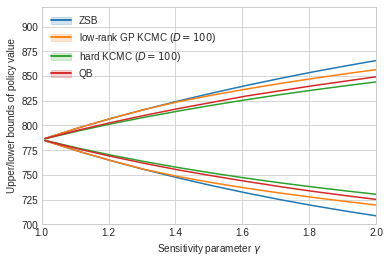

In [16]:
colors = {method: tab10((0.5 + i) / 10) for i, method in enumerate(grid_methods.keys())}
legend_targets = []
legend_tags = ["ZSB", "low-rank GP KCMC ($D=100$)", "hard KCMC ($D=100$)", "QB"]

for method_name in grid_methods.keys():
    upper = np.array([values_mean.loc[(method_name, lambd)]['upper_bound'] for lambd in grid_lambd])
    lower = np.array([values_mean.loc[(method_name, lambd)]['lower_bound'] for lambd in grid_lambd])
    dupper = np.array([values_std.loc[(method_name, lambd)]['upper_bound'] for lambd in grid_lambd])
    dlower = np.array([values_std.loc[(method_name, lambd)]['lower_bound'] for lambd in grid_lambd])
    c = colors[method_name]
    upper_line = plt.plot(grid_lambd, upper, c=c)[0]
    lower_line = plt.plot(grid_lambd, lower, c=c)[0]
    upper_band = plt.fill_between(grid_lambd, upper + dupper, upper - dupper, color=c, alpha=0.1)
    lower_band = plt.fill_between(grid_lambd, lower + dlower, lower - dlower, color=c, alpha=0.1)
    legend_targets.append((upper_line, lower_line, upper_band, lower_band))

plt.legend(legend_targets, legend_tags)
plt.xlabel(r"Sensitivity parameter $\gamma$")
plt.ylabel(r"Upper/lower bounds of policy value")
plt.xlim([1.0, 2.0])
plt.ylim([700, 920])
plt.savefig('logs/policy_evaluation_real_binary_changing_lambda.pdf')

### Ground Truth

In [8]:
evaluate_policy(toy_policy, n=1000000)

tensor(3.8210, dtype=torch.float64)

### IPW estimator

In [9]:
est_ipw = ipw(Y, T, X, p_t, toy_policy)

In [10]:
est_ipw

tensor(4.1126, dtype=torch.float64)

### Hajek estimator

In [11]:
est_hajek = hajek(Y, T, X, p_t, toy_policy)

In [14]:
est_hajek

tensor(6988.2551, dtype=torch.float64)

### Implement Confounding Robust Inference

In [15]:
kcmc.estimators.f_divergences

['KL',
 'inverse KL',
 'Jensen-Shannon',
 'squared Hellinger',
 'Pearson chi squared',
 'Neyman chi squared',
 'total variation']

### Compare Policy Learning Performance

In [32]:
def base_policy(X, T):
    n = X.shape[0]
    return 0.5 * torch.ones(n, dtype=float)

def LR_policy(X, T, beta):
    n = X.shape[0]
    T = torch.as_tensor(T)
    X = np.concatenate([np.ones([n, 1]), X], axis=1)
    p = torch.sigmoid(torch.tensor(X) @ beta)
    return (1 - T) * p + T * (1 - p)

In [33]:
class nnPolicy(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.nn = torch.nn.Sequential(
            torch.nn.Linear(5, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 1),
            torch.nn.Sigmoid(),
        )
        self.nn[-2].weight.data[:] = 0.
        self.nn[-2].bias.data[:] = 0.

    def forward(self, X, T):
        X = torch.as_tensor(X, dtype=torch.float32)
        T = torch.as_tensor(T)
        p = self.nn(X)[:, 0]
        return (1 - T) * p + T * (1 - p)

In [70]:
@wrap_continuous_policy
def base_policy(X):
    mu_t = 0.5 * torch.ones(X.shape[0])
    a, b = 10 * mu_t + 1, 10 * (1 - mu_t) + 1
    return torch.distributions.beta.Beta(a, b)

def LR_policy(X, beta):
    X = np.concatenate([np.ones([X.shape[0], 1]), X], axis=1)
    mu_t = torch.sigmoid(torch.tensor(X) @ beta)
    a, b = 10 * mu_t + 1, 10 * (1 - mu_t) + 1
    return torch.distributions.beta.Beta(a, b)

In [64]:
class nnPolicy(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.nn = torch.nn.Sequential(
            torch.nn.Linear(5, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 1),
            torch.nn.Sigmoid(),
        )
        self.nn[-2].weight.data[:] = 0.
        self.nn[-2].bias.data[:] = 0.
    
    def forward(self, X):
        X = torch.as_tensor(X, dtype=torch.float32)
        mu_t = torch.sigmoid(self.nn(X)[:, 0])
        a, b = 10 * mu_t + 1, 10 * (1 - mu_t) + 1
        return torch.distributions.beta.Beta(a, b)

In [65]:
evaluate_policy(base_policy, n=100000)

tensor(3.7413, dtype=torch.float64)

In [66]:
nn_policy = wrap_continuous_policy(nnPolicy())
evaluate_policy(nn_policy, n=100000)

tensor(3.7534, dtype=torch.float64)

#### Best Policy

In [72]:
train_steps = 101
beta_best = torch.zeros(6, requires_grad=True, dtype=float)
best_policy = wrap_continuous_policy(lambda X: LR_policy(X, beta_best))
optimizer = torch.optim.RMSprop(lr=1e-1, params=[beta_best])
pbar = tqdm(range(train_steps))
for i in pbar:
    value = evaluate_policy(best_policy, n=100000, requires_grad=True)
    (- value).backward()
    optimizer.step()
    optimizer.zero_grad()
    pbar.set_description(f"Value: {value}")

  0%|          | 0/101 [00:00<?, ?it/s]

In [ ]:
train_steps = 101
beta_best = torch.zeros(6, requires_grad=True, dtype=float)
best_policy = lambda X, T: LR_policy(X, T, beta_best)
optimizer = torch.optim.RMSprop(lr=1e-1, params=[beta_best])
pbar = tqdm(range(train_steps))
for i in pbar:
    value = evaluate_policy(best_policy, n=100000)
    (- value).backward()
    optimizer.step()
    optimizer.zero_grad()
    pbar.set_description(f"Value: {value}")

#### Just Run Hajek optimization

In [55]:
train_steps = 101
beta_hajek = torch.zeros(6, requires_grad=True, dtype=float)
hajek_policy = lambda X, T: LR_policy(X, T, beta_hajek)
optimizer = torch.optim.RMSprop(lr=1e-1, params=[beta_hajek])
pbar = tqdm(range(train_steps))
for i in pbar:
    value = hajek(Y, T, X, p_t, hajek_policy)
    (- value).backward()
    optimizer.step()
    optimizer.zero_grad()
    pbar.set_description(f"Value: {value}")

  0%|          | 0/101 [00:00<?, ?it/s]

In [56]:
evaluate_policy(hajek_policy, n=100000)

tensor(4.6822, dtype=torch.float64, grad_fn=<MeanBackward0>)

### Just run min-max optimzation

In [57]:
def evaluate_confounding_robust_hajek(policy):
    est = confounding_robust_estimator(
        Y, T, X, p_t, policy, 
        lambd=1.5, hajek_const=True, tan_box_const=True,
    )
    return est

In [58]:
def evaluate_confounding_robust_kernel(policy):
    est = confounding_robust_estimator(
        Y, T, X, p_t, policy, 
        D=200, lambd=1.5, alpha=0.05, 
        sigma2=sigma2, kernel=kernel,
        kernel_const=True,
        tan_box_const=True,
    )
    return est

In [60]:
# Hajek policy min-max value
train_steps = 101
beta_hajek = torch.zeros(6, requires_grad=True, dtype=float)
hajek_policy = lambda X, T: LR_policy(X, T, beta_hajek)
optimizer = torch.optim.SGD(lr=1e-1, params=[beta_hajek])
pbar = tqdm(range(train_steps))
for i in pbar:
    hajek_value = evaluate_confounding_robust_hajek(hajek_policy)
    (- hajek_value).backward()
    optimizer.step()
    optimizer.zero_grad()
    pbar.set_description(f"Value: {hajek_value}")

  0%|          | 0/101 [00:00<?, ?it/s]

In [61]:
evaluate_policy(hajek_policy, n=100000)

tensor(4.4034, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [62]:
evaluate_confounding_robust_kernel(hajek_policy)

tensor(4.0741, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [63]:
# Kernel policy min-max value
train_steps = 101
beta_kernel = torch.zeros(6, requires_grad=True, dtype=float)
kernel_policy = lambda X, T: LR_policy(X, T, beta_kernel)
optimizer = torch.optim.RMSprop(lr=1e-1, params=[beta_kernel])
pbar = tqdm(range(train_steps))
for i in pbar:
    kernel_value = evaluate_confounding_robust_kernel(kernel_policy)
    (- kernel_value).backward()
    optimizer.step()
    optimizer.zero_grad()
    pbar.set_description(f"Value: {kernel_value}")

  0%|          | 0/101 [00:00<?, ?it/s]

In [64]:
evaluate_policy(kernel_policy, n=100000)

tensor(4.6240, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [65]:
evaluate_confounding_robust_kernel(kernel_policy)

tensor(4.4347, dtype=torch.float64, grad_fn=<MeanBackward0>)